In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import re
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
calls_df = pd.read_csv('/content/callsf0d4f5a.csv')
reasons_df = pd.read_csv('/content/reason18315ff.csv')
test_df = pd.read_csv('/content/testbc7185d.csv')

In [ ]:
merged_df = pd.merge(calls_df, reasons_df, on='call_id')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    filler_words = ['uhh', 'umm', 'yeah', 'okay', 'alright', 'like', 'you know', 'agent', 'customer', 'know',
                    'really', 'rest', 'high', 'help', 'let', 'look', 'pull', 'hi', 'thanks', 'youre', 'typing']
    text = ' '.join(word for word in text.split() if word.lower() not in filler_words)

    agent_phrases = [
        r'thank you for calling united airlines customer service.*?',
        r'thank you for your patience.*?',
        r'(my name is .*? how may i help you\?)',
        r'(thank you for flying with us.*)'
    ]
    for phrase in agent_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)

    contractions = {"don't": "do not", "can't": "cannot", "i'm": "i am", "it's": "it is", "isn't": "is not"}
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text, flags=re.IGNORECASE)

    text = re.sub(r'[^a-zA-Z\s\?\!]', '', text)
    text = text.lower()

    domain_specific_stopwords = ['flight', 'airline', 'reservation', 'book', 'united']
    all_stopwords = stop_words.union(domain_specific_stopwords)
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in all_stopwords)

    return text

merged_df['cleaned_transcript'] = merged_df['call_transcript'].apply(preprocess_text)

In [ ]:
merged_df['primary_call_reason'] = (
    merged_df['primary_call_reason']
    .str.strip()
    .str.lower()
    .str.replace(r'\s+', ' ', regex=True)
)

In [ ]:
X = merged_df['cleaned_transcript']
y = merged_df['primary_call_reason']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

model = RandomForestClassifier(class_weight=class_weights, n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight={'baggage': 1.0405510889079697,
                                     'booking': 1.0915008597396216,
                                     'check in': 7.5027437737441955,
                                     'check-in': 1.8756859434360489,
                                     'checkout': 1.54145467160037,
                                     'communications': 0.7519778871511373,
                                     'digital support': 2.3900493052442853,
                                     'disability': 7.313400082293239,
                                     'etc': 3.0706593723006046,
                                     'irrops': 0.21979027551070882,
                                     'mileage plu...
                                     'post-flight': 0.7281243172383658,
                                     'products & services': 5.944481605351171,
                                     'products and services': 1.015038452752608,
                                     'schedule change': 3.9629877369007804,
                                     'seating': 0.45191965420798375,
                                     'traveler updates': 3.103544613235551,
                                     'unaccompanied minor': 28.979347826086958,
                                     'upgrade': 1.0610287533578748,
                                     'voluntary cancel': 1.8211687557635166,
                                     'voluntary change': 0.2656523233742359},
                       random_state=42)

In [42]:
y_pred = model.predict(X_test_tfidf)

In [43]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0    0    0    0    0    0    0    0    0  490    4    0    0    0
     0    0    0    3    0    0    0    0  107]
 [   0    0    0    0    0    0    0    0    0  393    3    0    0    0
     0    0    0    6    0    0    0    0  111]
 [   0    0    0    0    0    0    0    0    0   64    0    0    0    0
     0    0    0    0    0    0    0    0   12]
 [   0    0    0    0    0    0    0    0    0  226    1    0    0    0
     0    0    0    1    0    0    0    0   55]
 [   0    0    0    0    0    0    0    0    0  311    2    0    0    0
     0    0    0    3    0    0    0    0   68]
 [   0    0    0    0    0    1    0    0    0  598    2    0    0    0
     0    0    0   11    0    0    0    0  145]
 [   0    0    0    0    0    0    0    0    0  209    2    0    0    0
     0    0    0    1    0    1    0    0   42]
 [   0    0    0    0    0    0    0    0    0   67    1    0    0    0
     0    0    0    1    0    0    0    0   17]
 [   0    0    0    0    0    0    0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

              baggage       0.00      0.00      0.00       604
              booking       0.00      0.00      0.00       513
             check in       0.00      0.00      0.00        76
             check-in       0.00      0.00      0.00       283
             checkout       0.00      0.00      0.00       384
       communications       0.25      0.00      0.00       757
      digital support       0.00      0.00      0.00       255
           disability       0.00      0.00      0.00        86
                  etc       0.00      0.00      0.00       197
               irrops       0.21      0.80      0.33      2763
         mileage plus       0.04      0.00      0.00      1130
         other topics       0.00      0.00      0.00       174
          post flight       0.00      0.00      0.00        75
          post-flight       0.00      0.00      0.00       773
  products & services       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


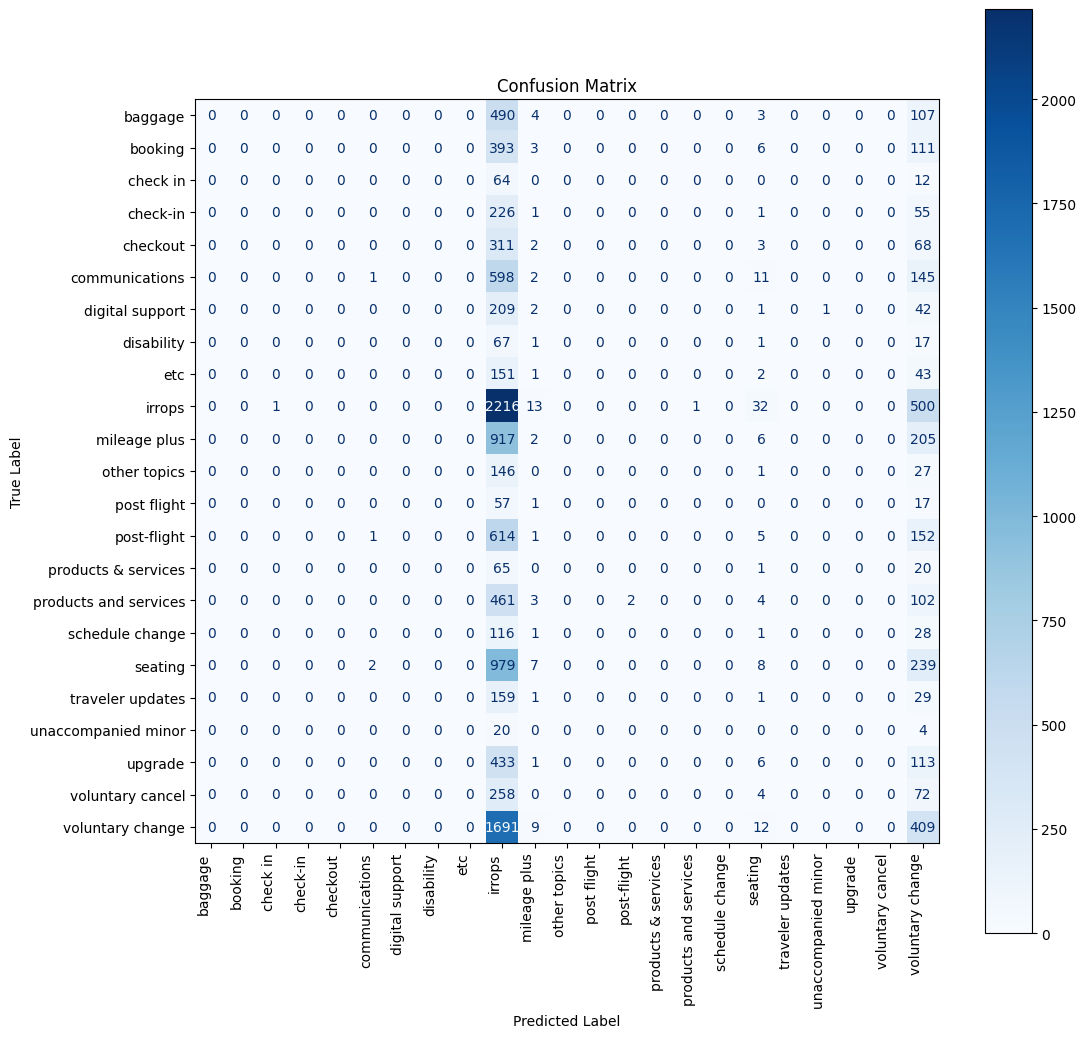

In [45]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90, ha='right')
plt.show()

In [ ]:
print(calls_df.columns)
print(test_df.columns)

Index(['call_id', 'customer_id', 'agent_id', 'call_start_datetime',
       'agent_assigned_datetime', 'call_end_datetime', 'call_transcript'],
      dtype='object')
Index(['call_id'], dtype='object')


In [41]:
test_merged_df = pd.merge(test_df, calls_df[['call_id', 'call_transcript']], on='call_id', how='left')

test_merged_df['cleaned_transcript'] = test_merged_df['call_transcript'].apply(preprocess_text)

test_tfidf = vectorizer.transform(test_merged_df['cleaned_transcript'])

test_predictions = model.predict(test_tfidf)

test_merged_df['predicted_call_reason'] = test_predictions

test_merged_df['call_id'] = test_merged_df['call_id'].astype(str)
output_file_path = '/content/predictions.csv'
test_merged_df[['call_id', 'predicted_call_reason']].to_csv(output_file_path, index=False)

print(f"Predictions saved to {output_file_path}")

Predictions saved to /content/predictions.csv
